<a href="https://colab.research.google.com/github/SanidhyaSharma28/News-Junkie/blob/master/detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [5]:

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [6]:

from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/gdrive/MyDrive/data/platelet_data/train-images/labels_my-project-name_2024-02-15-11-17-21.json", "/content/gdrive/MyDrive/data/platelet_data/train-images")
register_coco_instances("my_dataset_val", {}, "/content/gdrive/MyDrive/data/platelet_data/eval-images/labels_my-project-name_2024-02-16-01-10-40.json", "/content/gdrive/MyDrive/data/platelet_data/eval-images")



In [7]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

[02/16 09:49:42 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/gdrive/MyDrive/data/platelet_data/train-images/labels_my-project-name_2024-02-15-11-17-21.json


In [8]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[02/16 09:49:42 d2.data.datasets.coco]: Loaded 2 images in COCO format from /content/gdrive/MyDrive/data/platelet_data/eval-images/labels_my-project-name_2024-02-16-01-10-40.json


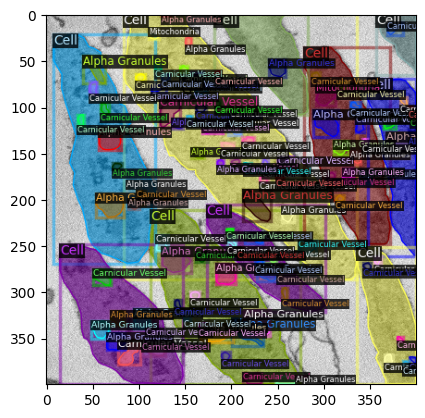

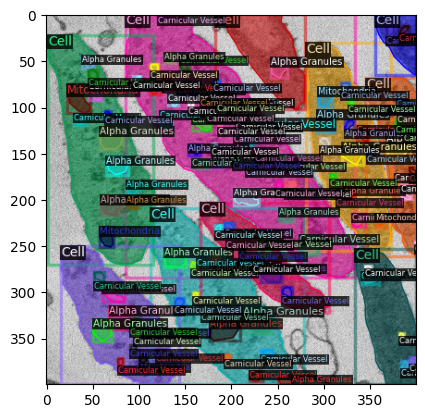

In [9]:
from matplotlib import pyplot as plt


"Visualizer is used to visualize annotations on images."
"[:, :, ::-1] reverses the order of the color channels to go from BGR to RGB, which is the format expected by Matplotlib."

# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [10]:

from detectron2.engine import DefaultTrainer

cfg = get_cfg() #Creates a configuration object that holds various settings and hyperparameters for training the model.
cfg.OUTPUT_DIR = "/content/gdrive/MyDrive/models/detectron2"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
#Merges the settings from the Mask R-CNN architecture configuration file for the COCO dataset.
#This file contains default configurations for the Mask R-CNN model.
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2   #number of worker processes to use for data loading during training so 2 processors will be used to make it faster
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Sets the initial weights for the model to a pre-trained Mask R-CNN model from the Detectron2 model zoo.
cfg.SOLVER.IMS_PER_BATCH = 2  # basically batch_size
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
#This parameter determines how many ROI proposals will be sampled per image during training.during training, the model will randomly sample 256 ROIs from each image for processing.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # Specifies number of rois without background

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Attempts to resume training from a previous checkpoint if available; otherwise, it starts training from scratch.

[02/16 09:49:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [11]:
trainer.train() #Start the training process

[02/16 09:49:46 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/16 09:49:56 d2.utils.events]:  eta: 0:10:24  iter: 19  total_loss: 7.102  loss_cls: 1.588  loss_box_reg: 0.5953  loss_mask: 0.6936  loss_rpn_cls: 3.696  loss_rpn_loc: 0.5065    time: 0.4111  last_time: 0.4286  data_time: 0.0278  last_data_time: 0.0074   lr: 4.9953e-06  max_mem: 1854M
[02/16 09:50:07 d2.utils.events]:  eta: 0:09:47  iter: 39  total_loss: 3.902  loss_cls: 1.453  loss_box_reg: 0.5296  loss_mask: 0.6901  loss_rpn_cls: 0.8721  loss_rpn_loc: 0.4211    time: 0.4027  last_time: 0.3717  data_time: 0.0100  last_data_time: 0.0059   lr: 9.9902e-06  max_mem: 1856M
[02/16 09:50:16 d2.utils.events]:  eta: 0:09:37  iter: 59  total_loss: 3.253  loss_cls: 1.29  loss_box_reg: 0.4144  loss_mask: 0.6838  loss_rpn_cls: 0.4415  loss_rpn_loc: 0.3851    time: 0.4046  last_time: 0.3877  data_time: 0.0131  last_data_time: 0.0113   lr: 1.4985e-05  max_mem: 1856M
[02/16 09:50:24 d2.utils.events]:  eta: 0:09:30  iter: 79  total_loss: 2.965  loss_cls: 1.059  loss_box_reg: 0.4868  loss_mask: 0.67

In [12]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/content/gdrive/MyDrive/models/detectron2/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)
#Writes the configuration cfg to the opened YAML file file. The yaml.dump() function serializes the Python object (cfg) into a YAML representation and writes it to the file.

In [13]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold . This threshold determines the minimum confidence score required for detected objects to be considered valid detections
predictor = DefaultPredictor(cfg)

[02/16 10:00:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/gdrive/MyDrive/models/detectron2/model_final.pth ...


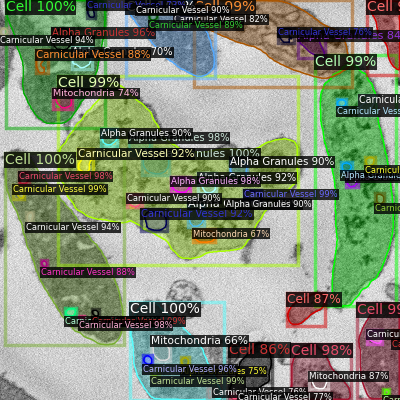

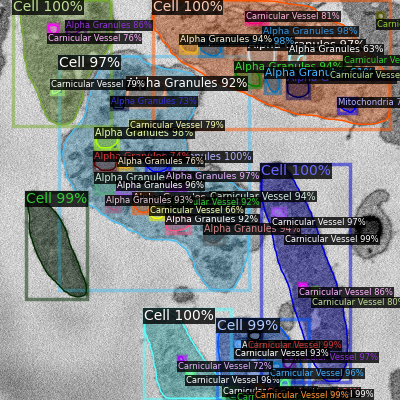

In [14]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 2):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # unsegmented pixels will be displayed without color.
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[02/16 10:00:34 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[02/16 10:00:34 d2.data.datasets.coco]: Loaded 2 images in COCO format from /content/gdrive/MyDrive/data/platelet_data/eval-images/labels_my-project-name_2024-02-16-01-10-40.json
[02/16 10:00:34 d2.data.build]: Distribution of instances among all 4 categories:
|   category   | #instances   |   category    | #instances   |   category    | #instances   |
|:------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|     Cell     | 30           | Carnicular .. | 67           | Alpha Granu.. | 32           |
| Mitochondria | 16           |               |              |               |              |
|    total     | 145          |               |              |               |              |
[02/16 10:00:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, s

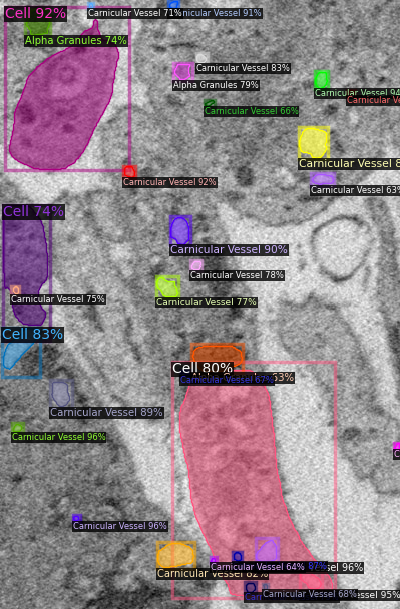

In [16]:
new_im = cv2.imread("/content/gdrive/MyDrive/data/platelet_data/test-images/image_10.jpg")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

In [25]:
import os

for i in range(0, 53):
    new_im = cv2.imread(f"/content/gdrive/MyDrive/data/platelet_data/test-images/image_{i}.jpg")
    outputs = predictor(new_im)

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    image_name = f"result_{i}.png"
    output_path = os.path.join("/content/gdrive/MyDrive/data/platelet_data/test_results", image_name)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

    # cv2_imshow(out.get_image()[:, :, ::-1])


In [29]:
import os
import cv2
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer
# Output directory where the segmented images will be saved
output_directory = "/content/gdrive/MyDrive/data/platelet_data/test_results_instance"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for i in range(0,53):
    image_path = f"/content/gdrive/MyDrive/data/platelet_data/test-images/image_{i}.jpg"
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # Create a dictionary to store the mask for each class with unique integer labels
    class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.uint8, device=torch.device("cuda:0"))
                   for class_name in train_metadata.thing_classes}

    # Assign a unique integer label to each object in the mask
    for i, pred_class in enumerate(outputs["instances"].pred_classes):
        class_name = train_metadata.thing_classes[pred_class]
        class_masks[class_name] = torch.where(outputs["instances"].pred_masks[i].to(device=torch.device("cuda:0")),
                                              i + 1,
                                              class_masks[class_name])

    # Save the masks for each class with unique integer labels
    for class_name, class_mask in class_masks.items():
        # Convert the tensor to a NumPy array and then to a regular (CPU) array
        class_mask_np = class_mask.cpu().numpy()

        # Create the output filename with _class_name_result.png extension
        class_filename = os.path.splitext(image_filename)[0] + f"_{class_name}_result.png"
        class_output_path = os.path.join(output_directory, class_filename)

        # Save the image with unique integer labels
        cv2.imwrite(class_output_path, class_mask_np.astype(np.uint8))

print("Segmentation of all images completed.")

Segmentation of all images completed.
